#**Predictive Maintenance for Oil & Gas Pump Operation**
**Accenture 2C**

##**Objective**
We plan to examine pump operational data, prepare it for machine learning modeling, and uncover relationships between features and pump status (running vs. faulty). This report outlines dataset characteristics, preprocessing steps, correlation patterns, temporal behavior, and actionable insights to guide the next phase of predictive modeling.

## Load the data


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving combined_pump_timeseries.csv to combined_pump_timeseries (1).csv


In [ ]:
df = df.drop_duplicates()
after = df.shape[0]
print(after)

720050


In [ ]:
import pandas as pd

import io
df = pd.read_csv('combined_pump_timeseries.csv')
df.columns

Index(['timestamp', 'pump_throughput_m3ph', 'operating_pressure_bar',
       'vibration_mm_s', 'bearing_temp_C', 'status', 'pump_number'],
      dtype='object')

In [ ]:
df.head()

,timestamp,pump_throughput_m3ph,operating_pressure_bar,vibration_mm_s,bearing_temp_C,status,pump_number
0,2025-04-15 20:14:00.388595,101.948189,9.911733,1.151807,63.317134,RUNNING,1
1,2025-04-15 20:24:00.388595,97.350999,10.015090,1.222389,67.622323,RUNNING,1
2,2025-04-15 20:34:00.388595,98.642862,9.890661,1.284898,67.834281,RUNNING,1
3,2025-04-15 20:44:00.388595,101.125591,10.136244,1.010065,64.876550,RUNNING,1
4,2025-04-15 20:54:00.388595,102.167705,10.048706,0.981551,69.590331,RUNNING,1


In [ ]:
df.tail()

,timestamp,pump_throughput_m3ph,operating_pressure_bar,vibration_mm_s,bearing_temp_C,status,pump_number
720045,2025-07-24 19:34:00.388595,98.430545,10.291101,1.287550,68.181174,RUNNING,50
720046,2025-07-24 19:44:00.388595,101.143881,10.045616,0.902897,68.818643,RUNNING,50
720047,2025-07-24 19:54:00.388595,99.224023,10.154750,0.943011,67.481187,RUNNING,50
720048,2025-07-24 20:04:00.388595,99.748459,10.310334,1.251775,70.447909,RUNNING,50
720049,2025-07-24 20:14:00.388595,99.410176,9.683489,1.105546,69.322490,RUNNING,50


In [ ]:
df.shape

(720050, 7)

##**Extract the Data**
### Identify variable types





**Reasoning**:
Iterate through each column in the DataFrame, determine its data type, and append the column name to the appropriate list based on its data type.



In [ ]:
numerical_sensor_cols = ['pump_throughput_m3ph', 'operating_pressure_bar', 'vibration_mm_s', 'bearing_temp_C']
meta_cols = ['timestamp', 'status', 'pump_number']  # keep track if you want to encode pump_number later

for c in numerical_sensor_cols + meta_cols:
    if c not in df.columns:
        raise KeyError(f"Expected column '{c}' not found in CSV")

print("Sensor numeric cols:", numerical_sensor_cols)
print("Meta cols:", meta_cols)

Sensor numeric cols: ['pump_throughput_m3ph', 'operating_pressure_bar', 'vibration_mm_s', 'bearing_temp_C']
Meta cols: ['timestamp', 'status', 'pump_number']


In [ ]:
df['status'].unique()

array(['RUNNING', 'DOWN'], dtype=object)

The dataset consists of numerical and categorical variables capturing pump performance and operating conditions.
* Numerical features:
* vibration_mm_s
* bearing_temp_C
* pump_throughput_m3ph
* Operating_pressure_bar

Categorical features:
* timestamp (later decomposed into date, hour, minute, second)
* pump_status (binary encoded: running/faulty)

Target variable:
* status, representing the operational condition of the pump.

---



**Below we are understanding the time series variable**

In [ ]:
df['timestamp'].value_counts()

,count
timestamp,
2025-07-24 20:14:00.388595,50
2025-07-24 17:34:00.388595,50
2025-07-24 17:24:00.388595,50
2025-07-24 17:14:00.388595,50
2025-07-24 17:04:00.388595,50
...,...
2025-04-15 21:04:00.388595,50
2025-04-15 20:54:00.388595,50
2025-04-15 20:44:00.388595,50


In [ ]:
len(df['timestamp'].unique().tolist())

14401

Here we see that there are 14401 unique time stamps in the data to test on.

**Get the Features and the label**



change the categorical label column to 0 or 1

In [ ]:
df['status'] = df['status'].astype(str).str.strip().str.upper().map(lambda v: 1 if v == 'DOWN' else 0)
print("Status value counts:\n", df['status'].value_counts())

Status value counts:
 status
0    671600
1     48450
Name: count, dtype: int64


##**Clean the data/Feature Engineering**

**SPLIT DATA TO PREVENT DATA LEAKAGE**

Then we move to data cleaning/feature engineering

### Handle categorical variables


**Reasoning**:
Standardize the categorical variables as per instructions.
- Time series data: Divide into corresponding numerical conversions (hours, minutes, seconds)
- Status: Changed to binary



In [ ]:
total_nan = df.isna().sum().sum()
print(f"Total number of NaN values: {total_nan}")
if total_nan > 0:
    print("NaNs per column:")
    print(df.isna().sum())
    df.dropna(inplace=True)
    print(f"After dropping NaNs, total number of NaN values: {df.isna().sum().sum()}")

Total number of NaN values: 0


No NaN values. So we can divide into corresponding numerical conversions now

In [ ]:
#check status head
print(df['status'].shape)
df['status'].head()

(720050,)


,status
0,0
1,0
2,0
3,0
4,0


In [ ]:
def add_time_features(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    if df['timestamp'].isna().any():
        print("Dropping unparsable timestamps:", df['timestamp'].isna().sum())
        df = df.dropna(subset=['timestamp']).reset_index(drop=True)

    # date/time breakdown (safe, vectorized)
    df['timestamp_date'] = df['timestamp'].dt.date
    df['timestamp_time'] = df['timestamp'].dt.time
    df['timestamp_hour'] = df['timestamp'].dt.hour
    df['timestamp_minute'] = df['timestamp'].dt.minute
    df['timestamp_second'] = df['timestamp'].dt.second + df['timestamp'].dt.microsecond / 1e6
    # continuous seconds-of-day if useful
    df['timestamp_seconds_of_day'] = df['timestamp_hour'] * 3600 + df['timestamp_minute'] * 60 + df['timestamp_second']
    return df

df = add_time_features(df)


**Create an unstandardized/untouched df to split into training and testing sets**

In [ ]:
df.head()

,timestamp,pump_throughput_m3ph,operating_pressure_bar,vibration_mm_s,bearing_temp_C,status,pump_number,timestamp_date,timestamp_time,timestamp_hour,timestamp_minute,timestamp_second,timestamp_seconds_of_day
0,2025-04-15 20:14:00.388595,101.948189,9.911733,1.151807,63.317134,0,1,2025-04-15,20:14:00.388595,20,14,0.388595,72840.388595
1,2025-04-15 20:24:00.388595,97.350999,10.015090,1.222389,67.622323,0,1,2025-04-15,20:24:00.388595,20,24,0.388595,73440.388595
2,2025-04-15 20:34:00.388595,98.642862,9.890661,1.284898,67.834281,0,1,2025-04-15,20:34:00.388595,20,34,0.388595,74040.388595
3,2025-04-15 20:44:00.388595,101.125591,10.136244,1.010065,64.876550,0,1,2025-04-15,20:44:00.388595,20,44,0.388595,74640.388595
4,2025-04-15 20:54:00.388595,102.167705,10.048706,0.981551,69.590331,0,1,2025-04-15,20:54:00.388595,20,54,0.388595,75240.388595


At this point, split the unscaled data on timestamp, that way you don't randomly spilt on a time series, and the same pump doesn't appear in both sets. Moreover, we can train on older data with newer data.

In [ ]:
master_df = df  # canonical DataFrame used for all subsequent steps
# create a "date" column for chronological splitting (already present as timestamp_date)
master_df['date'] = pd.to_datetime(master_df['timestamp_date'])

### **Handle numerical variables in original df for Data Analysis**
Normalize numerical features using a suitable scaling method (e.g., StandardScaler or MinMaxScaler).


**Reasoning**:
Normalize the numerical features using StandardScaler.



In [ ]:
# from sklearn.preprocessing import StandardScaler

# trainscaler = StandardScaler()
# trainscaler.fit(df[numerical_cols])
# df_numerical_scaled = pd.DataFrame(trainscaler.transform(df[numerical_cols]), columns=numerical_cols)
# display(df_numerical_scaled.head())

## Combine processed data

### Subtask:
Combine the standardized categorical and normalized numerical data into a single DataFrame.


**Reasoning**:
Concatenate the one-hot encoded categorical features and the scaled numerical features into a single DataFrame.



In [ ]:
# df_processed = df.drop(columns=numerical_cols).copy()
# df_processed = pd.concat([df_processed, df_numerical_scaled], axis=1)
# display(df_processed.head())

We can now add timestamp features, and run our Data Analysis

##**Data Exploration/Statistical Analysis**
Here, our main concern is understanding the relationship between the features and our label. This can help us determine which features should be considered for the actual model training. There some features that are redundent, like the time, and using all three may very well cause overfitting. Additionally, we will graph the time, as it is categorical, and the

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

###**Time Series Analysis**

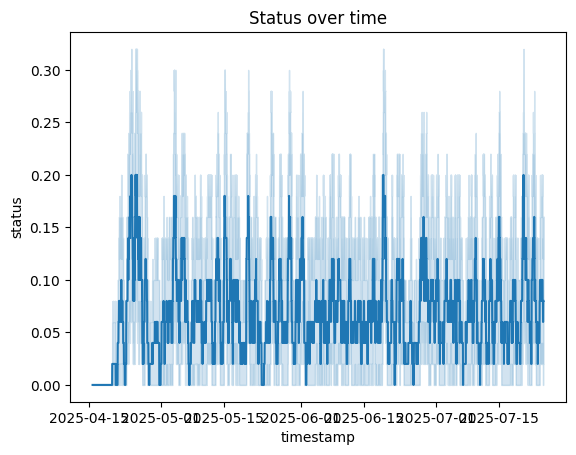

In [ ]:
sns.lineplot(data=master_df, x='timestamp', y='status')
plt.title("Status over time")
plt.show()

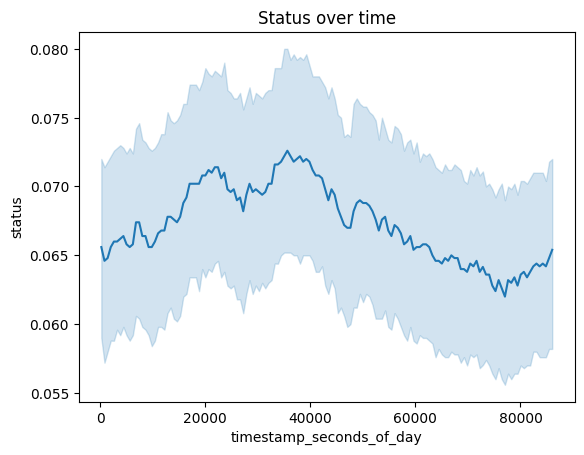

In [ ]:
sns.lineplot(data=master_df, x='timestamp_seconds_of_day', y='status')
plt.title("Status over time")
plt.show()

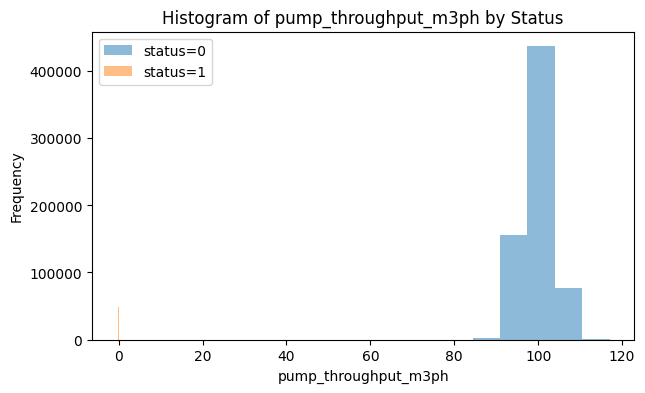

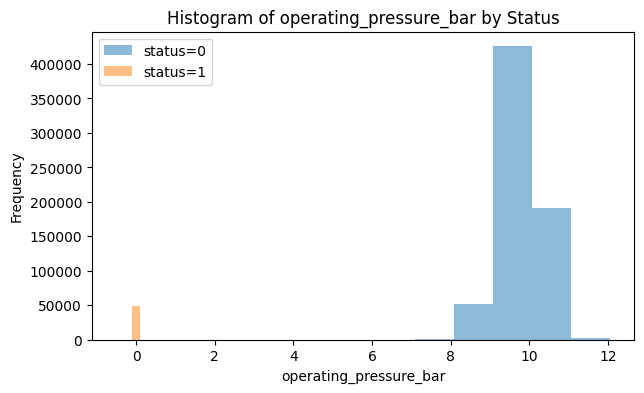

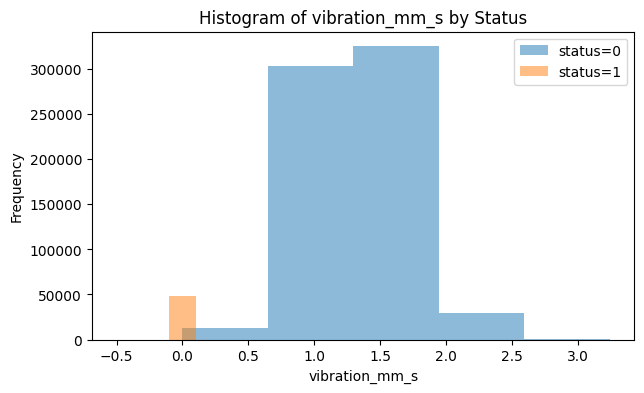

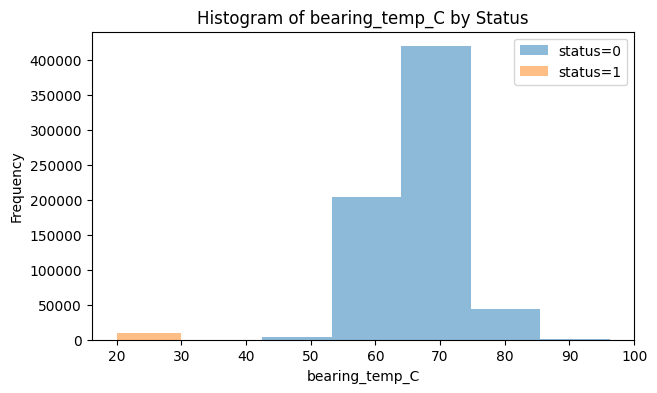

In [ ]:
for col in numerical_sensor_cols:
    plt.figure(figsize=(7,4))

    for cat in df["status"].unique():   # or any other categorical column
        subset = df[df["status"] == cat][col].dropna()
        plt.hist(subset, bins=5, alpha=0.5, label=f"status={cat}")

    plt.legend()
    plt.title(f"Histogram of {col} by Status")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


/tmp/ipython-input-1382038217.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='status', y=col, data=master_df, errorbar='sd', palette='viridis')


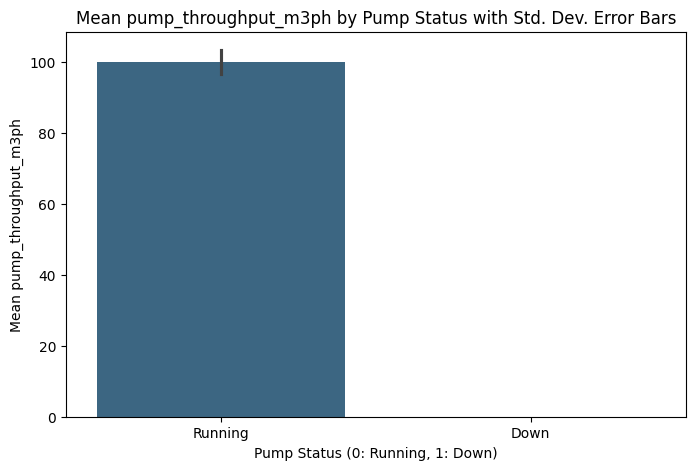

/tmp/ipython-input-1382038217.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='status', y=col, data=master_df, errorbar='sd', palette='viridis')


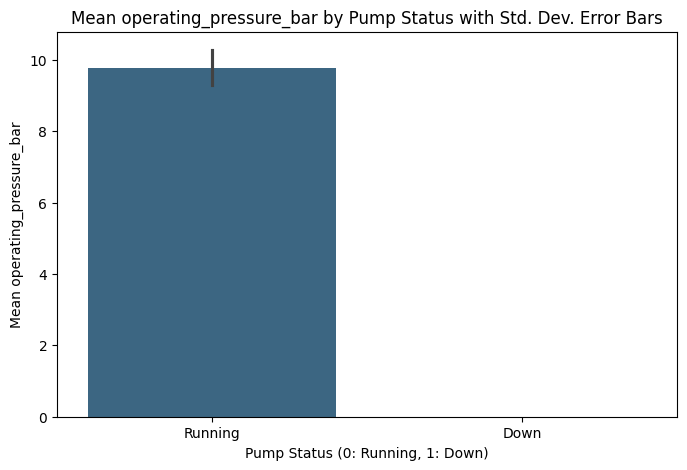

/tmp/ipython-input-1382038217.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='status', y=col, data=master_df, errorbar='sd', palette='viridis')


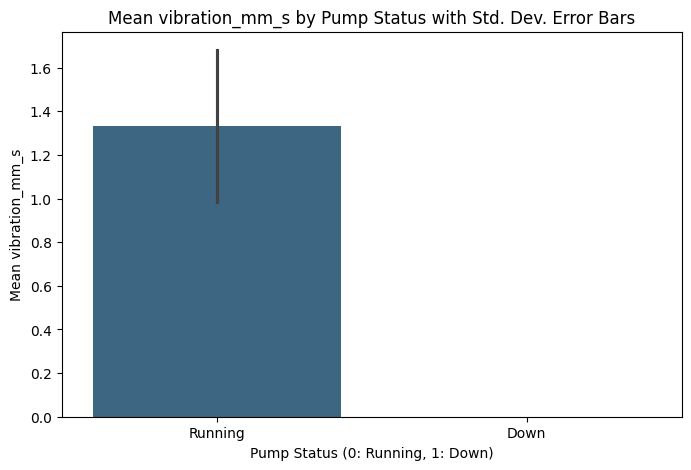

/tmp/ipython-input-1382038217.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='status', y=col, data=master_df, errorbar='sd', palette='viridis')


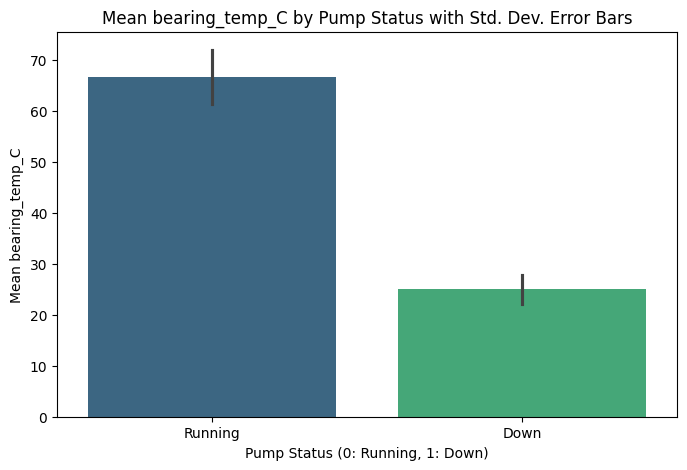

In [ ]:
for col in numerical_sensor_cols:
  plt.figure(figsize=(8, 5))
  sns.barplot(x='status', y=col, data=master_df, errorbar='sd', palette='viridis')
  plt.title(f'Mean {col} by Pump Status with Std. Dev. Error Bars')
  plt.xlabel('Pump Status (0: Running, 1: Down)')
  plt.ylabel(f'Mean {col}')
  plt.xticks(ticks=[0, 1], labels=['Running', 'Down'])
  plt.show()

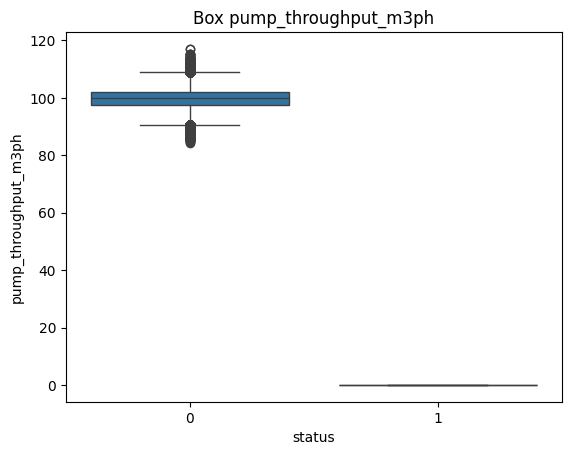

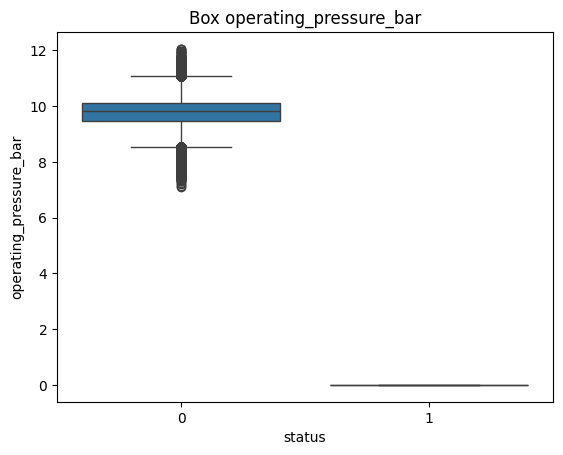

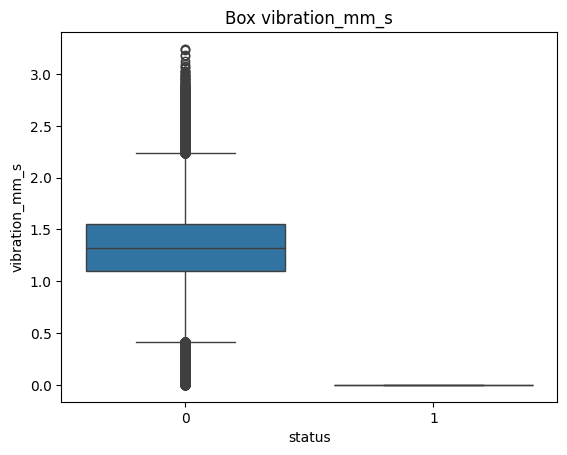

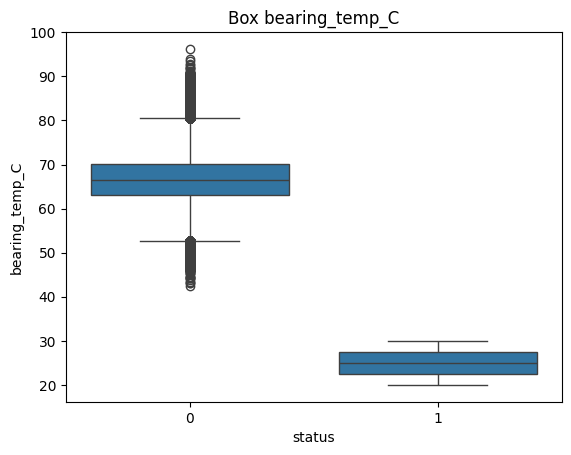

In [ ]:
for col in numerical_sensor_cols:
    plt.figure()
    sns.boxplot(x="status", y=col, data=df)
    plt.title(f"Box {col}")
    plt.show()

In [ ]:

# for col in numerical_cols_to_check:
#     plt.figure(figsize=(8, 5))
#     sns.boxplot(y=col, data=df_processed, palette='viridis')
#     plt.title(f'Box Plot of {col}')
#     plt.ylabel(col)
#     plt.show()

Here, we see some clear outliers in the pressure, temperature, vibration, and pump throughput. The data is about symmetrical for both categories, but there are reoccuring outliers for the running category, both inner fence and outer fence outliers in relation to the boxplot. However, the category we want to prioritize are the down pumps, which have no outliers whatsoever. Additionally,these outliers are also very frequent, so it may be meaningful to keep them in the training data, as they are very representative of real expectations. Thus, no winsorization will occurr.

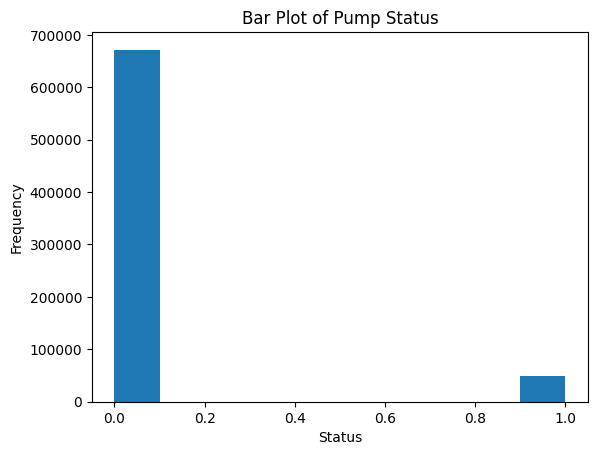

In [ ]:
plt.hist(master_df['status'])
plt.xlabel('Status')
plt.ylabel("Frequency")
plt.title("Bar Plot of Pump Status")
plt.show()

We see a small quantity of non-functional gas pumps. Only around 8% of the dataset is includes non-functional pumps reaffirming the need for advanced sampling techniques when creating test data.

In hopes of understanding relationships between features and label, as well as analyzing the linearality of the graph to see possible model candididates, I will analyze the correlations.

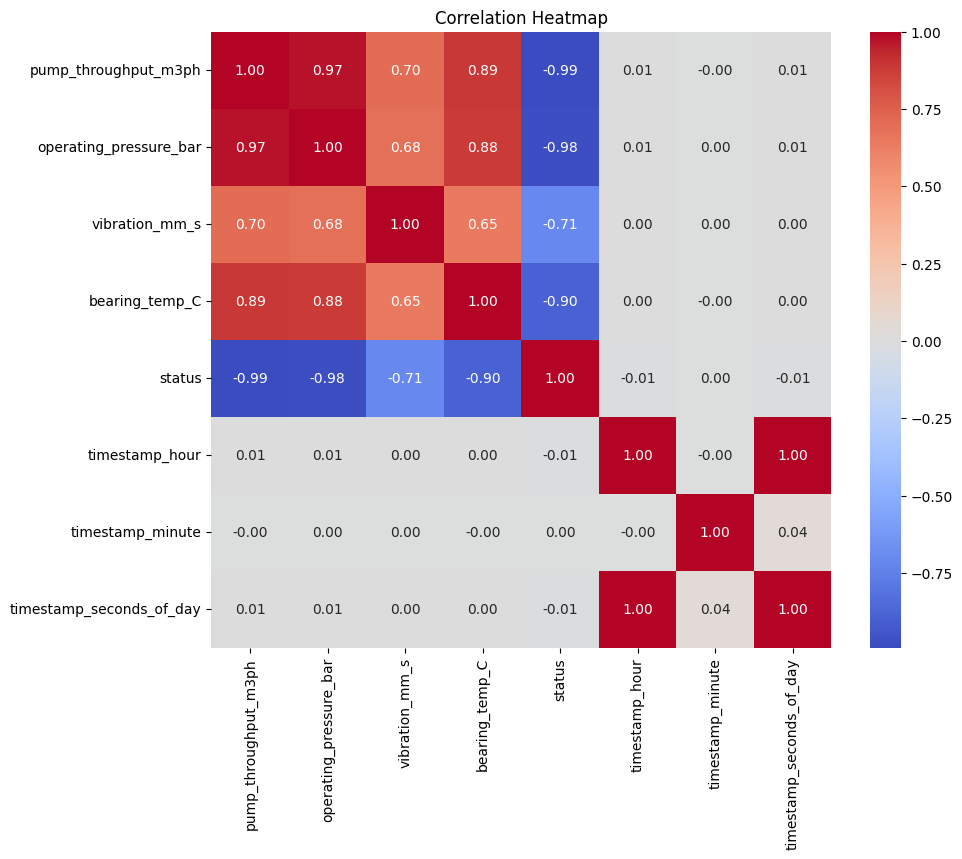

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(master_df.drop(columns = ['timestamp_date', 'timestamp_time','timestamp', 'date', 'timestamp_second', 'pump_number'],inplace = False).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## Summary:

### Key Findings

* The dataset contains both numerical and categorical variables.

* Numerical columns include pump_speed, outlet_pressure, flow_rate, motor_current, motor_voltage, motor_power, and vibration.

* Categorical columns include timestamp and pump_status.

* Categorical variables were successfully standardized using one-hot encoding, creating new columns for each unique category (e.g., timestamp_..., pump_status_...).

* Numerical features were successfully normalized using StandardScaler.

* The standardized categorical and normalized numerical data were combined into a single processed DataFrame.

* Date and time were separated into distinct columns, and time was computed as hours, minutes, and seconds to test suitability for training.

* Correlation analysis showed that timestamp features have little correlation with the label, except for hour, which may be somewhat useful.

* Running pumps are overrepresented in the dataset, creating class imbalance.

* There were clear outliers when analyzing the box plot, but they were deemed acceptable, as they were represented within their respective labels

* Thankfully, there were no null or missing data.

### Insights / Next Steps

* Consider excluding time features in modeling, except for hour, which showed the strongest (though still weak) relationship with status.

* Include date as a feature despite low correlation, since the plot suggests some visual relationship with status.

* Apply stratification or resampling to address class imbalance.

* The dataset is now ready for machine learning modeling.

* Due to the dataset’s size, it will be efficient to train models using PyTorch on GPU.

#**MILESTONE 2**

We can complete this given the information we have gathered on data analysis, which we will complete with a standardized data set

Logistic Regression --> high linear correlations between the data, and it's a lightweight model that doesn't take a lot of computational cost

Removed pump_number to prevent any chances for a data leakage, and time because there is low correlation between the time and feature.

In [ ]:
day_counts = master_df.groupby('date').size().sort_index()
cum = day_counts.cumsum() / day_counts.sum()
cut_date = cum[cum >= 0.70].index[0]

train_mask = master_df['date'] <= cut_date
test_mask  = master_df['date'] >  cut_date

feature_cols = numerical_sensor_cols + ['timestamp_seconds_of_day', 'timestamp_hour', 'timestamp_minute', 'timestamp_second']
X_train = master_df.loc[train_mask, feature_cols].reset_index(drop=True)
y_train = master_df.loc[train_mask, 'status'].reset_index(drop=True)
X_test  = master_df.loc[test_mask, feature_cols].reset_index(drop=True)
y_test  = master_df.loc[test_mask, 'status'].reset_index(drop=True)
print("Shapes:", X_train.shape, X_test.shape)
print("Train class counts:\n", y_train.value_counts())

Shapes: (505150, 8) (214900, 8)
Train class counts:
 status
0    471803
1     33347
Name: count, dtype: int64


In [ ]:
X_train.drop(columns=['timestamp_seconds_of_day', 'timestamp_hour', 'timestamp_minute', 'timestamp_second'],inplace = True)
X_test.drop(columns=['timestamp_seconds_of_day', 'timestamp_hour', 'timestamp_minute', 'timestamp_second'],inplace = True)


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(505150, 4) (505150,)
(214900, 4) (214900,)


**NOW SCALE TRAINING DATA**

Transform both training and testing sets by the same fitted scaler.

In [ ]:
from sklearn.preprocessing import StandardScaler
sensor_scaler = StandardScaler()
sensor_scaler.fit(X_train[numerical_sensor_cols])
X_train_sensors = pd.DataFrame(sensor_scaler.transform(X_train[numerical_sensor_cols]), columns=numerical_sensor_cols)
X_test_sensors  = pd.DataFrame(sensor_scaler.transform(X_test[numerical_sensor_cols]), columns=numerical_sensor_cols)


Apply SMOTE to ensure it is a balanced data set

In [ ]:
from imblearn.over_sampling import SMOTE
n_minority = int(y_train.sum())
if n_minority < 6:
    raise ValueError("Too few minority samples for SMOTE; use undersampling or collect more failures.")

# Example: use SMOTE but do not let it expand to full majority; control sampling_strategy
smote = SMOTE(random_state=42, k_neighbors=min(5, max(1, n_minority-1)), sampling_strategy=0.5)
# sampling_strategy=0.5 means minority will become 50% of majority size after resampling
X_resampled, y_resampled = smote.fit_resample(X_train_sensors, y_train)
# keep X_resampled as DataFrame (if needed)
X_train_res = pd.DataFrame(X_resampled, columns=X_test_sensors .columns)
y_train_res = pd.Series(y_resampled)
print("After SMOTE:", X_train_res.shape, y_train_res.value_counts().to_dict())

After SMOTE: (707704, 4) {0: 471803, 1: 235901}


In [ ]:
y_train.value_counts()

,count
status,
0,471803
1,33347


##**Logistic Regression Function**
We are using a single linear layer to represent our Logisitic Regression. We are using sigmoid to convert our outputs into predictions, as the base outputs are probability logits.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
X_train_arr = X_train_res.values.astype('float32')
y_train_arr = y_train_res.values.astype('float32')
X_test_arr  = X_test_sensors.values.astype('float32')
y_test_arr  = y_test.values.astype('float32')

train_ds = TensorDataset(torch.from_numpy(X_train_arr), torch.from_numpy(y_train_arr))
test_ds  = TensorDataset(torch.from_numpy(X_test_arr), torch.from_numpy(y_test_arr))

train_ds = DataLoader(train_ds, batch_size=64, shuffle=True)
test_ds  = DataLoader(test_ds, batch_size=64, shuffle=False)

input_dim = X_train_arr.shape[1]
model = LogisticRegressionModel(input_dim).to(device)

In [ ]:
n_pos = int((y_train_arr==1).sum())
n_neg = int((y_train_arr==0).sum())
pos_weight_val = n_neg / n_pos if n_pos > 0 else 1.0
pos_weight = torch.tensor(pos_weight_val, dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
for _ in range(1):
    model.train()
    for xb, yb in train_ds:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb).squeeze(), yb)
        loss.backward()
        optimizer.step()

In [ ]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_ds:
        xb = xb.to(device)
        probs = torch.sigmoid(model(xb).squeeze()).cpu().numpy()
        y_pred.append((probs >= 0.5).astype(int))
        y_true.append(yb.numpy())

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))


[[199742     55]
 [     0  15103]]
              precision    recall  f1-score   support

         0.0     1.0000    0.9997    0.9999    199797
         1.0     0.9964    1.0000    0.9982     15103

    accuracy                         0.9997    214900
   macro avg     0.9982    0.9999    0.9990    214900
weighted avg     0.9997    0.9997    0.9997    214900



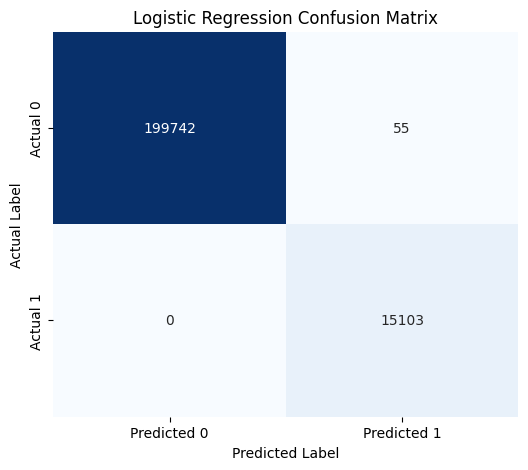

In [ ]:
cm_log = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0','Predicted 1'],
            yticklabels=['Actual 0','Actual 1'])
plt.title("Logistic Regression Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

Here, we saw stellar preformances by the Logistic Regression model, despite being such a lightweight model. This is largely due to the large linearity of the data. Additionally, it seems as though the time factor is not a very important feature, as the model is performing very well without it.

The model predicts 680 false running pumps; however, there are no innacurate predictions for down pumps, and that is our priority category, so we are in a very good position.

###KNearestNeighbors

In [ ]:
from sklearn.neighbors import (
    KNeighborsClassifier)

In [ ]:
KNN = KNeighborsClassifier()
KNN.fit(X_train_res, y_train_res)

KNeighborsClassifier()

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(KNN.predict(X_test_arr), y_test_arr))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


1.0


In [ ]:
y_pred_knn = KNN.predict(X_test_sensors)

print("=== K Nearest Neighbors — Test Metrics ===")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, digits=4, zero_division=0))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

=== K Nearest Neighbors — Test Metrics ===

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    199797
           1     1.0000    1.0000    1.0000     15103

    accuracy                         1.0000    214900
   macro avg     1.0000    1.0000    1.0000    214900
weighted avg     1.0000    1.0000    1.0000    214900


Confusion Matrix:
[[199797      0]
 [     0  15103]]


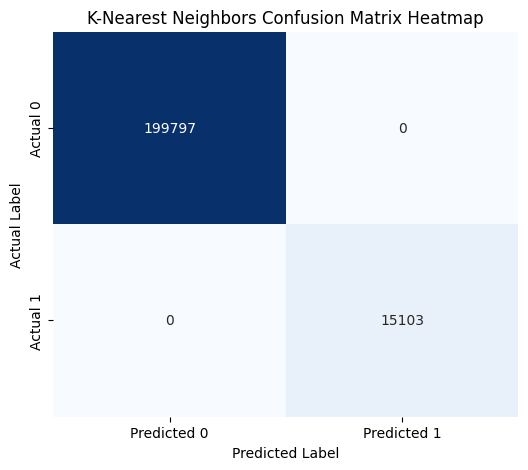

In [ ]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('K-Nearest Neighbors Confusion Matrix Heatmap')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

###DecisionTreeClassifier

In [ ]:
from sklearn.tree import (DecisionTreeClassifier)

In [ ]:
DT = DecisionTreeClassifier(random_state=42)
DT.fit(X_train_res, y_train_res)

DecisionTreeClassifier(random_state=42)

In [ ]:
DTpredictions = DT.predict(X_test_sensors)

print("=== Decision Tree — Test Metrics ===")
print("\nClassification Report:")
print(classification_report(y_test, DTpredictions, digits=4, zero_division=0))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, DTpredictions))

=== Decision Tree — Test Metrics ===

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    199797
           1     1.0000    1.0000    1.0000     15103

    accuracy                         1.0000    214900
   macro avg     1.0000    1.0000    1.0000    214900
weighted avg     1.0000    1.0000    1.0000    214900


Confusion Matrix:
[[199797      0]
 [     0  15103]]


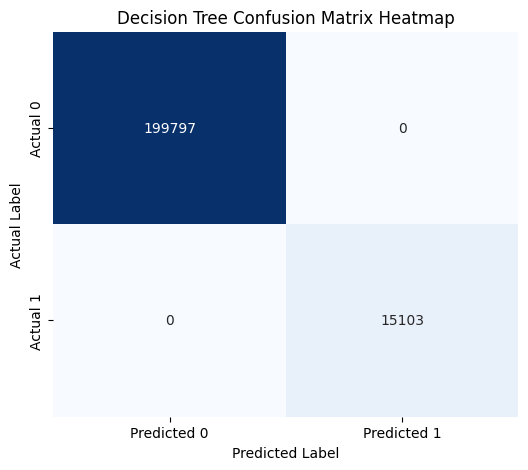

In [ ]:
cm_dt = confusion_matrix(y_test, DTpredictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Decision Tree Confusion Matrix Heatmap')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

###RandomForestClassifer

In [ ]:
from sklearn.ensemble import (RandomForestClassifier)

In [ ]:
RFmodel = RandomForestClassifier()
RFmodel.fit(X_train_arr, y_train_arr)

RandomForestClassifier()

In [ ]:
RFpredictions = RFmodel.predict(X_test_arr)
print("=== Random Forest — Test Metrics ===")
print("\nClassification Report:")
print(classification_report(y_test_arr, RFpredictions, digits=4, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_arr, RFpredictions))

=== Random Forest — Test Metrics ===

Classification Report:
              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000    199797
         1.0     1.0000    1.0000    1.0000     15103

    accuracy                         1.0000    214900
   macro avg     1.0000    1.0000    1.0000    214900
weighted avg     1.0000    1.0000    1.0000    214900


Confusion Matrix:
[[199797      0]
 [     0  15103]]


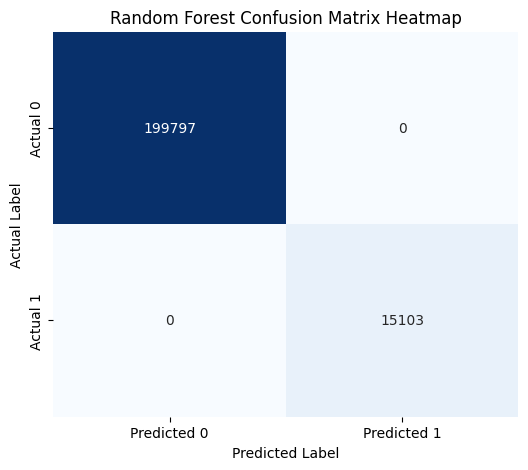

In [ ]:
cm_rf = confusion_matrix(y_test, RFpredictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Random Forest Confusion Matrix Heatmap')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

###Feed-Forward Nueral Network

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = torch.sigmoid(out)
        return out

In [ ]:
import torch

def train_feedforward_network(epochs, train_loader, model, criterion, optimizer, device):
  model.train()
  for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(train_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs.squeeze(), labels)

      loss.backward()
      optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score
)

def test_feedforward_network(test_loader, model, device, threshold=0.5):
  """
  Evaluate a trained binary feedforward neural network on a DataLoader.

    Args:
        test_loader: DataLoader over (X, y) with y in {0,1}
        model: trained PyTorch model whose forward returns sigmoid probabilities
        device: torch.device("cuda") or torch.device("cpu")
        threshold: decision threshold for positive class (default 0.5)

    Returns:
        metrics (dict): accuracy, precision, recall, f1, roc_auc, pr_auc,
                        confusion_matrix (2x2 list), support (tuple[int,int])
  """
  model.eval()
  y_true_list, y_score_list = [], []

  with torch.no_grad():
      for xb, yb in test_loader:
          xb = xb.to(device)
          yb = yb.to(device)

          probs = model(xb).squeeze()

          y_true_list.append(yb.detach().float().cpu())
          y_score_list.append(probs.detach().float().cpu())


  y_true = torch.cat(y_true_list).numpy()
  y_score = torch.cat(y_score_list).numpy()

  nn_pred = (y_score >= threshold).astype(np.int64)
  acc = accuracy_score(y_true, nn_pred)
  precision, recall, f1, support = precision_recall_fscore_support(
      y_true, nn_pred, average="binary", zero_division=0
  )
  try:
      roc_auc = roc_auc_score(y_true, y_score)
  except ValueError:
      roc_auc = float("nan")
  try:
      pr_auc = average_precision_score(y_true, y_score)
  except ValueError:
      pr_auc = float("nan")

  cm = confusion_matrix(y_true, nn_pred).tolist()

  print("=== FeedForward Network (PyTorch) — Test Metrics ===")
  print(f"Accuracy : {acc:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall   : {recall:.4f}")
  print(f"F1-score : {f1:.4f}")
  print(f"ROC AUC  : {roc_auc:.4f}")
  print(f"PR  AUC  : {pr_auc:.4f}\n")
  print("Confusion Matrix [[TN, FP], [FN, TP]]:")
  print(cm)
  print("\nClassification Report:")
  print(classification_report(y_true, nn_pred, digits=4, zero_division=0))

  return y_true, nn_pred, cm

In [ ]:
input_dim = X_train.shape[1]
hidden_dim = 32
ff_model = FeedForward(input_dim, hidden_dim)
ff_model.to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(ff_model.parameters(), lr=0.001)
epochs = 1

train_feedforward_network(epochs, train_ds, ff_model, criterion, optimizer, device)

Epoch [1/1], Loss: 0.0000


In [ ]:
y_true, y_nn_pred, cm_ffnn = test_feedforward_network(test_ds, ff_model, device)

=== FeedForward Network (PyTorch) — Test Metrics ===
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
ROC AUC  : 1.0000
PR  AUC  : 1.0000

Confusion Matrix [[TN, FP], [FN, TP]]:
[[199797, 0], [0, 15103]]

Classification Report:
              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000    199797
         1.0     1.0000    1.0000    1.0000     15103

    accuracy                         1.0000    214900
   macro avg     1.0000    1.0000    1.0000    214900
weighted avg     1.0000    1.0000    1.0000    214900



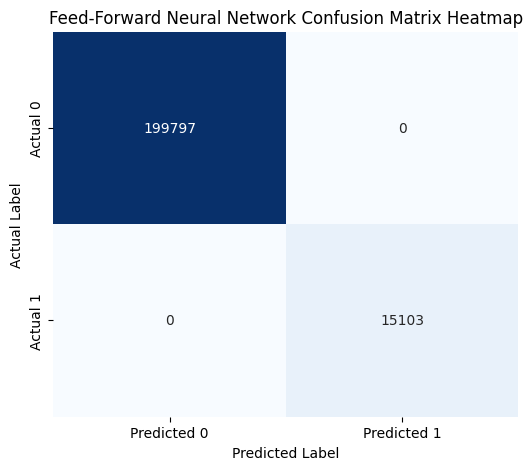

In [ ]:
cm_ffnn = confusion_matrix(y_true, y_nn_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_ffnn, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Feed-Forward Neural Network Confusion Matrix Heatmap')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

###Binary Sliding Window LSTM

In [ ]:
sequence_features = ['pump_throughput_m3ph',
                     'operating_pressure_bar',
                     'vibration_mm_s',
                     'bearing_temp_C']
target_col = 'status'

In [ ]:
split_index = int(len(df) * 0.70)

train_df = df.iloc[:split_index].copy()
test_df  = df.iloc[split_index:].copy()

X_train_raw = train_df[sequence_features].values
y_train_raw = train_df[target_col].values

X_test_raw  = test_df[sequence_features].values
y_test_raw  = test_df[target_col].values


In [ ]:

scaler = StandardScaler()
scaler.fit(X_train_raw)

X_train_scaled = scaler.transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)


In [ ]:
X_train_np = X_train.values
x_test_np = X_test.values

X_train_lstm = X_train_np.reshape((X_train_np.shape[0], 1, X_train_np.shape[1]))
x_test_lstm = x_test_np.reshape((x_test_np.shape[0], 1, x_test_np.shape[1]))

lstm_train_data = TensorDataset(torch.tensor(X_train_lstm, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
lstm_train_loader = DataLoader(lstm_train_data, batch_size=32, shuffle=True)
lstm_test_data = TensorDataset(torch.tensor(x_test_lstm, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))
lstm_test_loader = DataLoader(lstm_test_data, batch_size=32, shuffle=False)

print("X_train_lstm shape:", X_train_lstm.shape)
print("x_test_lstm shape:", x_test_lstm.shape)

X_train_lstm shape: (505150, 1, 4)
x_test_lstm shape: (214900, 1, 4)


In [ ]:
import numpy as np

def create_sequences(X, y, seq_len=24):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs, dtype='float32'), np.array(ys, dtype='float32')

In [ ]:
seq_len = 24  # 4 hours
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_raw, seq_len)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_raw, seq_len)

print(X_train_seq.shape, y_train_seq.shape)
print(X_test_seq.shape, y_test_seq.shape)

(504010, 24, 4) (504010,)
(215992, 24, 4) (215992,)


In [ ]:
class PumpLSTM(nn.Module):
    def __init__(self, num_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(
    torch.tensor(X_train_seq),
    torch.tensor(y_train_seq)
)
test_ds = TensorDataset(
    torch.tensor(X_test_seq),
    torch.tensor(y_test_seq)
)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = PumpLSTM(num_features=len(sequence_features)).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
epochs = 1

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb).squeeze()

        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}  Loss={total_loss/len(train_loader):.4f}")


Epoch 1/1  Loss=0.0110


In [ ]:
model.eval()
y_true, LSTM_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)

        y_true.extend(yb.numpy())
        LSTM_pred.extend(preds)

print(confusion_matrix(y_true, LSTM_pred))
print(classification_report(y_true, LSTM_pred, digits=4))


[[201219    151]
 [   151  14471]]
              precision    recall  f1-score   support

         0.0     0.9993    0.9993    0.9993    201370
         1.0     0.9897    0.9897    0.9897     14622

    accuracy                         0.9986    215992
   macro avg     0.9945    0.9945    0.9945    215992
weighted avg     0.9986    0.9986    0.9986    215992



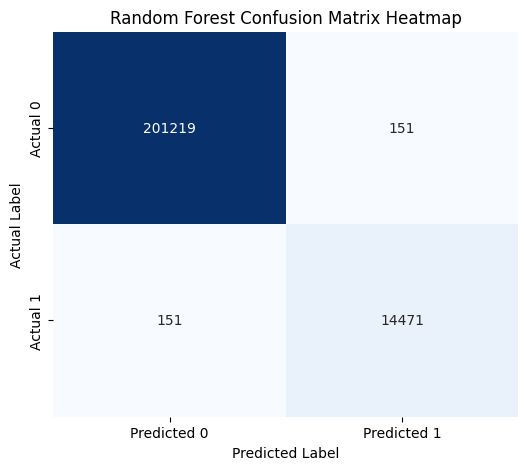

In [ ]:
cm_rf = confusion_matrix(y_true, LSTM_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Random Forest Confusion Matrix Heatmap')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Hyperparameter Tuning for Logistic Regression
Given the already stellar performance of the baseline Logistic Regression model, largely attributable to the distinct differences in features between running and faulty pumps, hyperparameter tuning might not lead to significant performance gains in terms of accuracy. However, tuning can still be valuable for finding a more robust and generalized model, potentially simplifying it further or making it more efficient without sacrificing performance.

We choose Linear Regression over the other non-linear models as it performed exceptionally well despite being a linear model. Other non-linear models such as KNN, Decision Trees, Random Forest, etc. may be prone to **overfitting**, thus we proceed with Logistic Regression.

We will use `GridSearchCV` to explore different values for the `C` parameter (inverse of regularization strength) and `penalty` type (L1 or L2 regularization).The goal of this tuning is to confirm robustness or find slightly better-suited parameters, especially in scenarios where real-world data might have subtle variations not captured perfectly in the current dataset.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],      # Specify L1 or L2 regularization
    'solver': ['liblinear']       # 'liblinear' supports both l1 and l2 penalties
}

# Create a Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter for convergence

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=3, scoring='f1', verbose=2, n_jobs=-1)

# Fit GridSearchCV to the SMOTEd training data
# X_train and y_train here are the SMOTEd and scaled training data
grid_search.fit(X_train_arr, y_train_arr)

print("Best parameters found: ", grid_search.best_params_)
print("Best F1-score found: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_log_reg_model = grid_search.best_estimator_
y_pred_tuned = best_log_reg_model.predict(X_test_arr)

print("\n=== Tuned Logistic Regression — Test Metrics ===")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, digits=4, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1-score found:  1.0

=== Tuned Logistic Regression — Test Metrics ===

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    199797
           1     1.0000    1.0000    1.0000     15103

    accuracy                         1.0000    214900
   macro avg     1.0000    1.0000    1.0000    214900
weighted avg     1.0000    1.0000    1.0000    214900


Confusion Matrix:
[[199797      0]
 [     0  15103]]


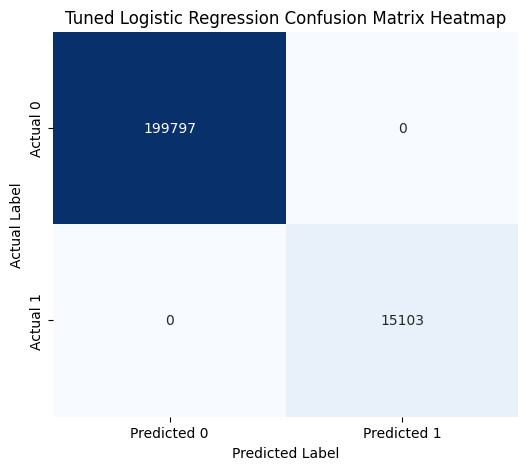

In [ ]:
cm_tuned_lr = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_tuned_lr, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Tuned Logistic Regression Confusion Matrix Heatmap')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

While 100% accuracy often raises a flag, in this specific case, it aligns perfectly with the clear separability observed in the data. Logistic Regression is now a robust and accurate model for this particular problem.

In [ ]:
import joblib

joblib.dump(sensor_scaler, "scaler.pkl")
joblib.dump(best_log_reg_model, "logreg_model.pkl")


['logreg_model.pkl']

### Visualizing Feature Distributions by Status in the Test Set
To understand why the models are achieving such high accuracy, let's visualize the distributions of each sensor feature for both 'RUNNING' (0) and 'DOWN' (1) statuses within the test set. This will help determine if the classes are perfectly separable based on the features.

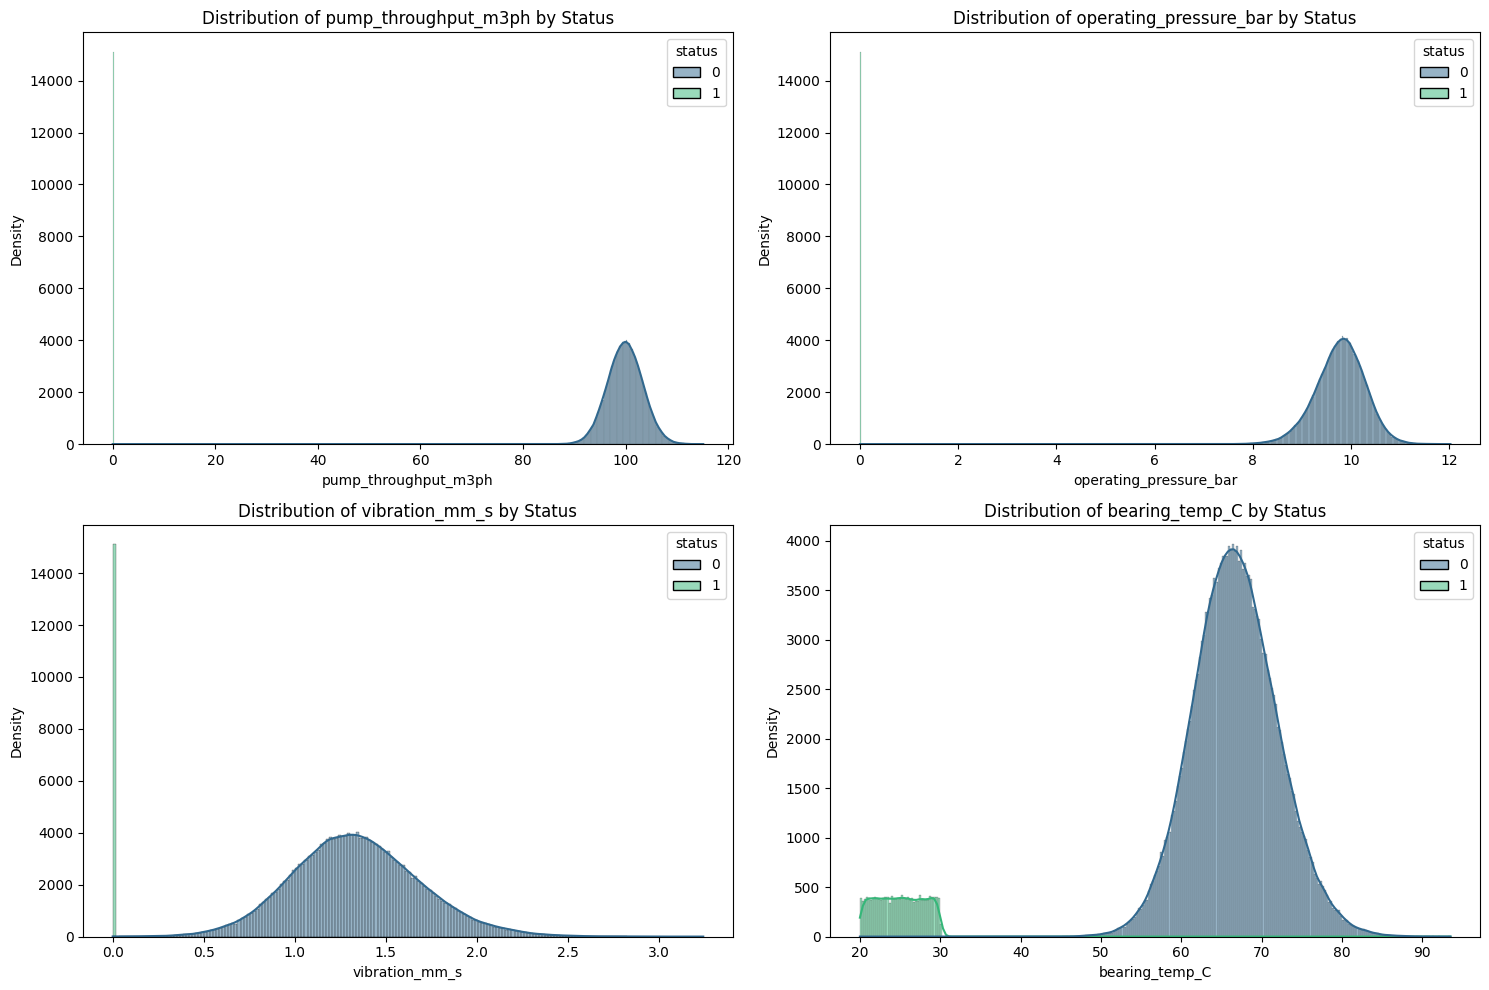

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for visualization from the test set
# We'll use the unscaled X_test to see original distributions, or scaled if preferred
test_df_viz = X_test.copy()
test_df_viz['status'] = y_test.values

plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_sensor_cols):
    plt.subplot(2, 2, i + 1)  # Assuming 4 numerical sensor columns, 2x2 grid
    sns.histplot(data=test_df_viz, x=col, hue='status', kde=True, palette='viridis', common_norm=False)
    plt.title(f'Distribution of {col} by Status')
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

# **Model Business Impact**
**Calculating Unplanned Downtime & Financial Metrics**


### Calculating Actual Unplanned Downtime (Baseline: 'Without Model')

To calculate the total unplanned downtime, we will:
1.  Ensure the 'timestamp' column is in datetime format.
2.  For each pump, identify periods where the 'status' is 'DOWN'.
3.  Given that data is sampled every 10 minutes, we'll assume each 'DOWN' record represents 10 minutes of downtime.
4.  Sum up these durations to get the total unplanned downtime across all pumps and the entire dataset.

In [ ]:
repeats = master_df['timestamp'].is_unique
print(f"Timestamps do not repeat throughout pumps: {repeats}")

Timestamps do not repeat throughout pumps: False


In [ ]:
# Calculate downtime (assuming each 'DOWN' entry represents 10 minutes)
# This is based on the observed 10-minute interval in the dataset
downtime_per_record_minutes = 10

# Filter for 'DOWN' status
down_events = master_df[master_df['status'] == 1]
repeats = down_events.groupby('pump_number')['timestamp'].apply(lambda x: x.is_unique)
print(f"Timestamps do not repeat within pumps:")
repeats

Timestamps do not repeat within pumps:


,timestamp
pump_number,
1,True
2,True
3,True
4,True
5,True
6,True
7,True
8,True
9,True


We see timestamps repeat within the dataset, but do not repeat within pumps, this means each fix is independent. In other words, we can have pump 1 and pump 50 down at the same time, however, they will both require fixing during the same time, so the hourly cost for fixing both would double as it's double the labor. Thus, we can calculate total downtime by multiplying total downtime in hours by it's hourly cost.

In [ ]:
# Group by pump_number and calculate the total count of 'DOWN' events for each pump
downtime_counts_per_pump = down_events.groupby('pump_number').size()

# Calculate total downtime in minutes
total_downtime_minutes = downtime_counts_per_pump.sum() * downtime_per_record_minutes
total_downtime_hours = total_downtime_minutes / 60
total_downtime_days = total_downtime_hours / 24

print(f"\nTotal actual unplanned downtime: {total_downtime_minutes:.2f} minutes")
print(f"Total actual unplanned downtime: {total_downtime_hours:.2f} hours")
print(f"Total actual unplanned downtime: {total_downtime_days:.2f} days")

#average downtime interval

# Calculate previous and next status within each pump group
# This creates temporary columns to identify status changes across records for the same pump.
master_df['prev_status'] = master_df.groupby('pump_number')['status'].shift(1)
master_df['next_status'] = master_df.groupby('pump_number')['status'].shift(-1)

# Identify start and end points of downtime intervals based on pseudocode's logic
# A downtime starts if the current status is 'DOWN' (1) and the previous status was 'RUNNING' (0)
# or if it's the very first record for a pump and its status is 'DOWN'.
master_df['downtime_start_flag'] = ((master_df['status'] == 1) & (master_df['prev_status'] == 0)) | \
                                   ((master_df['status'] == 1) & (master_df['prev_status'].isna()))

# A downtime ends if the current status is 'DOWN' (1) and the next status is 'RUNNING' (0)
# or if it's the very last record for a pump and its status is 'DOWN'.
master_df['downtime_end_flag'] = ((master_df['status'] == 1) & (master_df['next_status'] == 0)) | \
                                 ((master_df['status'] == 1) & (master_df['next_status'].isna()))

downtime_intervals_list = []

# Iterate through each pump to find and record downtime intervals
for pump_num, group_df in master_df.groupby('pump_number'):
    current_start_time = None
    # Iterate through the group's records to identify continuous 'DOWN' intervals
    for idx, row in group_df.iterrows():
        if row['downtime_start_flag']:
            current_start_time = row['timestamp']
        # If an end flag is found and a start time was recorded, calculate the interval
        if row['downtime_end_flag'] and current_start_time is not None:
            end_time = row['timestamp']
            # Calculate duration: difference between end and start timestamp, plus one interval's duration
            # to account for the actual time spent 'DOWN' at the end_time timestamp itself.
            duration = (end_time - current_start_time).total_seconds() / 60 + downtime_per_record_minutes
            downtime_intervals_list.append({
                'pump_number': pump_num,
                'start_time': current_start_time,
                'end_time': end_time,
                'duration_minutes': duration
            })
            current_start_time = None # Reset for the next interval

# Convert the list of intervals into a DataFrame for easier analysis
downtime_intervals_df = pd.DataFrame(downtime_intervals_list)
downtime_intervals_df['duration_hours'] = round(downtime_intervals_df['duration_minutes']/60,2)

# Calculate average interval time for each pump and overall average
if not downtime_intervals_df.empty:
    avg_downtime_interval_per_pump_minutes = downtime_intervals_df.groupby('pump_number')['duration_minutes'].mean()
    overall_avg_downtime_interval_minutes = downtime_intervals_df['duration_minutes'].mean()
    overall_avg_downtime_interval_hours = overall_avg_downtime_interval_minutes / 60
else:
    avg_downtime_interval_per_pump_minutes = pd.Series(dtype='float64')
    overall_avg_downtime_interval_minutes = 0
    overall_avg_downtime_interval_hours = 0

print("\n--- Downtime Interval Analysis---")
print("\nDowntime Intervals Data (first 5 records):")
display(downtime_intervals_df.head())
print("\nAverage Downtime Interval per Pump (minutes, first 5 pumps):")
display(avg_downtime_interval_per_pump_minutes.head())
print(f"\nOverall Average Downtime Interval: {overall_avg_downtime_interval_minutes:.2f} minutes ({overall_avg_downtime_interval_hours:.2f} hours)")

# Clean up temporary columns from master_df to keep it tidy
master_df = master_df.drop(columns=['prev_status', 'next_status', 'downtime_start_flag', 'downtime_end_flag'])

print("\n Downtime per pump")
display(downtime_counts_per_pump.head())



Total actual unplanned downtime: 484500.00 minutes
Total actual unplanned downtime: 8075.00 hours
Total actual unplanned downtime: 336.46 days

--- Downtime Interval Analysis---

Downtime Intervals Data (first 5 records):


,pump_number,start_time,end_time,duration_minutes,duration_hours
0,1,2025-04-24 10:34:00.388595,2025-04-25 03:34:00.388595,1030.0,17.17
1,1,2025-05-03 20:54:00.388595,2025-05-04 12:04:00.388595,920.0,15.33
2,1,2025-05-13 23:44:00.388595,2025-05-14 14:44:00.388595,910.0,15.17
3,1,2025-05-22 13:24:00.388595,2025-05-23 02:24:00.388595,790.0,13.17
4,1,2025-05-30 22:54:00.388595,2025-05-31 12:34:00.388595,830.0,13.83



Average Downtime Interval per Pump (minutes, first 5 pumps):


,duration_minutes
pump_number,
1,965.000000
2,996.363636
3,923.000000
4,988.000000
5,1022.222222



Overall Average Downtime Interval: 969.00 minutes (16.15 hours)

 Downtime per pump


,0
pump_number,
1,965
2,1096
3,923
4,988
5,920


**As mentioned in the oringal slides by Accenture, the overall average downtime per pump failure is 16.15 hours.**

We were also able to find the total unplanned downtime of 484,500 minutes. Although, this may seem alarming, as the original dataset includes only 100 days. We found pumps can fail simultaneously but are independent, thus the summation of downtimes can exceed 100 days.

### Estimating Downtime Saved 'With the Model'

Now that we have the baseline for total unplanned downtime, we can estimate the savings if our predictive model were in place. This requires pairng information from the orignal slides provided by Accenture with our finidings to compare planned versus unplanned costs (time and financial):

**From Accenture's Project Overview:**
*   **Cost of Unplanned Downtime (Baseline):** The total downtime calculated above. Each 'DOWN' event means 10 minutes of lost production.
*   "Unplanned downtimes take N(16,3) hours to resolve" (Accenture Slides)
* **We found average downtime is 16.15 hours, since our mean is roughly the same, we can proceed using Accenture's shared metrics for cost analysis.**
*   "Uptime valued at $10,000/hour" --> Downtime = -$10,000/hour (Accenture Slides)
*   **Response to True Positives (TP):** When the model correctly predicts an upcoming failure, maintenance can be scheduled.
*   "Planned downtimes take N(8,2) hours to resolve" (Accenture Slides)
*   On average planned downtimes take **50%** less time unplanned downtimes do—saving **$80,000**.
*   **Response to False Positives (FP):**
      When the model incorrectly predicts a failure, an inspection might occur. "FP costs 4 hours of operating time (1/4 Unplanned Downtime), plus repair cost." In other words, a False Positive **costs roughly $40,000**.
*   **Response to False Negatives (FN):** When the model misses a failure, the pump still experiences the full unplanned downtime of 16 hours per 'DOWN' event (as in the baseline).

Using our tuned Logistic Regression model, we can calculate the estimated downtime.

In [ ]:
# Use the confusion matrix from the best tuned Logistic Regression model
# cm_tuned_lr = [[TN, FP], [FN, TP]]
# As per the output of the previous cell:
# cm_tuned_lr = [[199797, 0], [0, 15103]]

#first downtime pump took 17 hours (I checked)

TN = cm_tuned_lr[0][0]
FP = cm_tuned_lr[0][1]
FN = cm_tuned_lr[1][0]
TP = cm_tuned_lr[1][1]

# Using average metrics from before model implementation
unplanned_downtime_duration = 10 # per actual 'DOWN' record
planned_maintenance_duration = 5 # half of unplanned
unnecessary_inspection_duration = 10/4 #1/4 unplanned downtime as slides entail

# Calculate estimated downtime 'with model'
estimated_downtime_minutes = (
    TP * planned_maintenance_duration +   # True Positives lead to planned, shorter maintenance
    FN * unplanned_downtime_duration +  # False Negatives are still unplanned failures
    FP * unnecessary_inspection_duration # False Positives lead to minor, short inspections
)

estimated_downtime_hours = estimated_downtime_minutes / 60
estimated_downtime_days = estimated_downtime_hours / 24

print(f"Estimated downtime with model: {estimated_downtime_minutes:.2f} minutes")
print(f"Estimated downtime with model: {estimated_downtime_hours:.2f} hours")
print(f"Estimated downtime with model: {estimated_downtime_days:.2f} days")

# Calculate the difference
saved_downtime_minutes = total_downtime_minutes - estimated_downtime_minutes
saved_downtime_hours = total_downtime_hours - estimated_downtime_hours
saved_downtime_days = total_downtime_days - estimated_downtime_days

print(f"\nSaved downtime: {saved_downtime_minutes:.2f} minutes")
print(f"Saved downtime: {saved_downtime_hours:.2f} hours")
print(f"Saved downtime: {saved_downtime_days:.2f} days")


Estimated downtime with model: 75515.00 minutes
Estimated downtime with model: 1258.58 hours
Estimated downtime with model: 52.44 days

Saved downtime: 408985.00 minutes
Saved downtime: 6816.42 hours
Saved downtime: 284.02 days


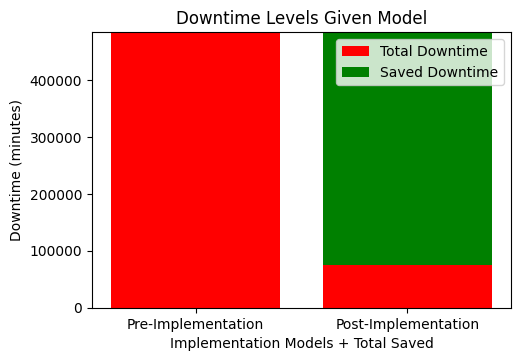

In [ ]:
categories = ['Pre-Implementation', 'Post-Implementation']
values = [total_downtime_minutes,estimated_downtime_minutes]
saved_values = [0, saved_downtime_minutes]

plt.bar(categories, values, color='r')
plt.bar(categories, saved_values, bottom=values, color='g')

#plt.bar(categories, values, color=bar_colors)
plt.xlabel('Implementation Models + Total Saved')
plt.ylabel('Downtime (minutes)')
plt.title('Downtime Levels Given Model')
plt.legend(['Total Downtime', 'Saved Downtime'])
plt.tight_layout(pad=5)

plt.show()


In [ ]:

total_reduction_in_downtime = saved_downtime_minutes/total_downtime_minutes
print(f"Total Reduction in Pump Downtime: {round(total_reduction_in_downtime*100,2)}%")

Total Reduction in Pump Downtime: 84.41%


With saved downtime of 408,985 minutes, equivalent to 6,816.42 hours. With hourly uptime costing $500, our model was able to:

* **Save $3,408,210** across the 100 days of gas pump operations by predicting failed gas pumps.

- $238,574 weekly

- $34,082 daily

* **Reduce** Pump Downtime by **84.41%**